In [1]:
import pandas as pd
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
DATASET_PATH = '../Data/Stanford_Online_Products/'
TRAIN_FILE = 'Ebay_train.txt'
TEST_FILE = 'Ebay_test.txt'
FULL_DATASET_FILE = 'Ebay_info.txt'

In [3]:
df_train = pd.read_csv(f'{DATASET_PATH}{TEST_FILE}', sep=' ')
df_train.head()

,image_id,class_id,super_class_id,path
0,59552,11319,1,bicycle_final/251952414262_0.JPG
1,59553,11319,1,bicycle_final/251952414262_1.JPG
2,59554,11319,1,bicycle_final/251952414262_2.JPG
3,59555,11319,1,bicycle_final/251952414262_3.JPG
4,59556,11319,1,bicycle_final/251952414262_4.JPG


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60502 entries, 0 to 60501
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_id        60502 non-null  int64 
 1   class_id        60502 non-null  int64 
 2   super_class_id  60502 non-null  int64 
 3   path            60502 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.8+ MB


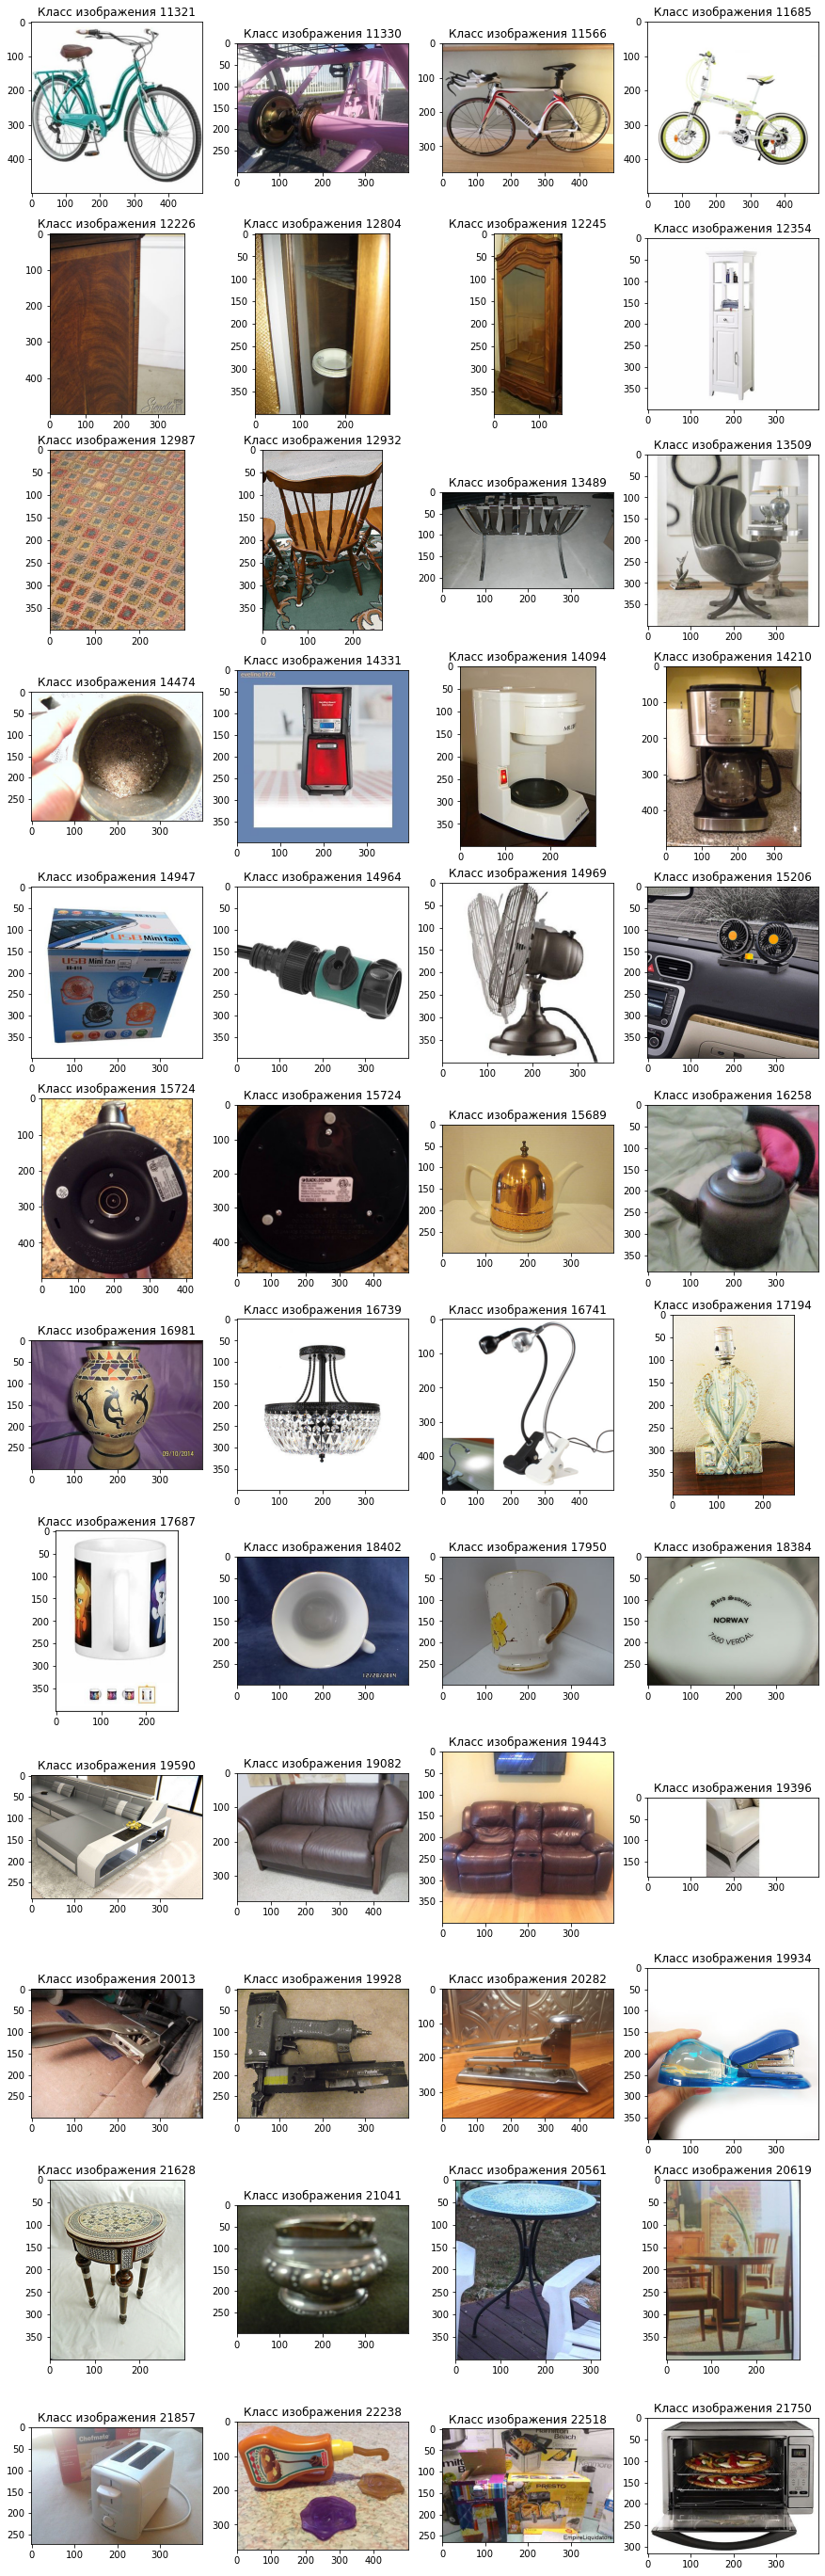

In [5]:
from random import choice

super_classes = df_train.super_class_id.unique()

fig, axes = plt.subplots(nrows=12, ncols=4, figsize=(15, 50))
for ax in range(len(super_classes)):
    super_class = super_classes[ax]
    for img in range(4):
        img_class_paths = df_train.loc[df_train.super_class_id == super_class, 'path'].values
        img_class_path = choice(img_class_paths)
        class_img = df_train.loc[df_train.path == img_class_path, 'class_id']
        img_class_full_path = f'{DATASET_PATH}{img_class_path}'
        img_class = cv2.cvtColor(cv2.imread(img_class_full_path), cv2.COLOR_BGR2RGB)
        axes[ax, img].set_title(f'Класс изображения {class_img.values[0]}')
        axes[ax, img].imshow(img_class)

Data Handler для Стэндфорского датасета


In [6]:
from random import sample
from tqdm import tqdm
import tensorflow_addons as tfa

FULL_DATASET_FILE = 'Ebay_info.txt'


class DatasetHandler:

    def __init__(self, dataset_dir,
                 split_dataset=(0.8, 0.2),
                 dataset_part=1,
                 batch_size=64,
                 target_shape=(400, 400)):

        self.__target_shape = target_shape
        self.dataset_dir = dataset_dir

        full_dataset = pd.read_csv(f'{self.dataset_dir}/{FULL_DATASET_FILE}', sep=' ')
        self.__dataset_partitions = split_dataset

        df_train, df_test = self.__split_dataset(full_dataset, dataset_part)

        # Train/test triplets

        tqdm.write(f'Train generating')
        train_triplets = self.__generate_triplets(df_train)
        self.__train_dataset = self.__seal_dataset(train_triplets)
        self.__train_dataset = self.__train_dataset.batch(batch_size).prefetch(2)
        tqdm.write(f'Test generating')
        test_triplets = self.__generate_triplets(df_test)
        self.__test_dataset = self.__seal_dataset(test_triplets)
        self.__test_dataset = self.__test_dataset.batch(batch_size).prefetch(2)

    def __split_dataset(self, data: pd.DataFrame, dataset_part: float):
        super_classes = list(data.super_class_id.unique())
        df_train = data.copy()
        df_test = data.copy()
        for super_class in super_classes:
            super_class_indexes = list(data.loc[data.super_class_id == super_class].index)
            dropped_index = sample(super_class_indexes, int(dataset_part * len(super_class_indexes)))
            dropped_index = list(set(super_class_indexes) - set(dropped_index))
            train_super_class_indexes = sample(super_class_indexes,
                                               int(self.__dataset_partitions[0] * len(super_class_indexes)))

            test_super_class_indexes = list(set(super_class_indexes) - set(train_super_class_indexes))

            df_train.drop(index=test_super_class_indexes + dropped_index, inplace=True)
            df_test.drop(index=train_super_class_indexes + dropped_index, inplace=True)
        return df_train, df_test

    def __form_triplet(self, ind: int, data: pd.DataFrame):
        anchor = data.iloc[ind]
        similar_indexes = data.loc[(data.class_id == anchor.class_id) & (data.image_id != anchor.image_id)].index
        if len(similar_indexes) == 0:
            similar_indexes = data.loc[(data.super_class_id == anchor.super_class_id)].index
        positive = data.loc[choice(similar_indexes)]
        different_indexes = data.drop(index=data.loc[data.class_id == anchor.class_id].index).index
        negative = data.loc[choice(different_indexes)]

        return anchor, positive, negative

    def __generate_triplets(self, data: pd.DataFrame):
        triplets = {'anchors': [], 'positive': [], 'negative': []}
        for i in tqdm(range(data.shape[0])):
            anchor, positive, negative = self.__form_triplet(i, data)
            triplets['anchors'].append(f'{DATASET_PATH}{anchor["path"]}')
            triplets['positive'].append(f'{DATASET_PATH}{positive["path"]}')
            triplets['negative'].append(f'{DATASET_PATH}{negative["path"]}')
        return triplets

    def __seal_dataset(self, data: dict):
        anchor_dataset = tf.data.Dataset.from_tensor_slices(data['anchors'])
        positive_dataset = tf.data.Dataset.from_tensor_slices(data['positive'])
        negative_dataset = tf.data.Dataset.from_tensor_slices(data['negative'])

        triplets_path_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
        triplets_images_dataset = triplets_path_dataset.map(self.__preprocess_triplets).map(self.__augmentation_triplets)

        return triplets_images_dataset

    @tf.autograph.experimental.do_not_convert
    def __augmentation_triplets(self, anchor, positive, negative):

        return (
            self.__augmentation_image(anchor),
            self.__augmentation_image(positive),
            self.__augmentation_image(negative),
        )

    def __augmentation_image(self, image):
        aug_image = tf.image.random_flip_left_right(image)
        aug_image = tf.image.random_flip_up_down(aug_image)
        aug_image = tf.image.random_brightness(aug_image, max_delta=0.3)
        aug_image = tf.image.random_contrast(aug_image, lower=0.6, upper=1)
        aug_image = tf.image.random_saturation(aug_image, 0.6, 1)
        aug_image = tf.image.rot90(aug_image, k=randint(0, 3))
        return aug_image

    def __preprocess_image(self, filename: tf.Tensor):
        """
        Load the specified file as a JPEG image, preprocess it and
        resize it to the target shape.
            """

        image_string = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, self.__target_shape)

        return image

    @tf.autograph.experimental.do_not_convert
    def __preprocess_triplets(self, anchor, positive, negative):
        """
        Given the filenames corresponding to the three images, load and
        preprocess them.
        """

        return (
            self.__preprocess_image(anchor),
            self.__preprocess_image(positive),
            self.__preprocess_image(negative),
        )

    def get_target_shape(self):
        return self.__target_shape

    def get_training_data(self):
        return self.__train_dataset

    def get_validation_data(self):
        return self.__test_dataset

In [7]:
from src.DatasetHandler import DatasetHandler

data_handler = DatasetHandler(dataset_dir=DATASET_PATH, split_dataset=(0.9, 0.1), dataset_part=0.1)

  0%|          | 25/10803 [00:00<00:44, 241.03it/s]

Train generating


100%|██████████| 10803/10803 [00:47<00:00, 228.53it/s]


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


  3%|▎         | 30/1197 [00:00<00:03, 293.46it/s]

Test generating


100%|██████████| 1197/1197 [00:04<00:00, 266.96it/s]


In [8]:
train = data_handler.get_training_data()
test = data_handler.get_validation_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


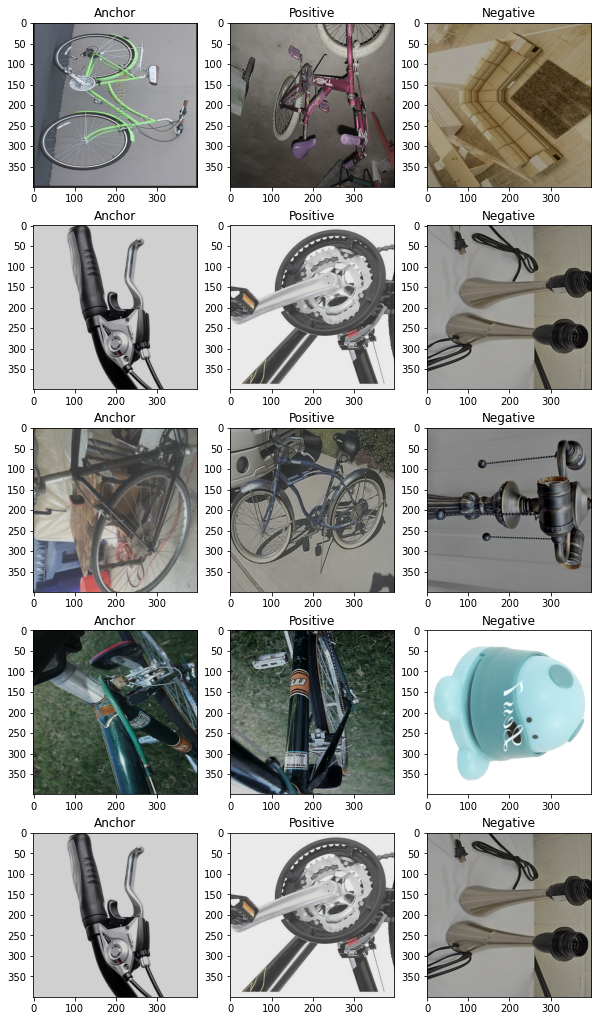

In [9]:
from random import randint

a, p, n = next(iter(train))

fig, axes = plt.subplots(5, 3, figsize=(10, 18))
for i in range(5):
    img = randint(0, 31)
    axes[i, 0].set_title('Anchor')
    axes[i, 0].imshow(a[img].numpy())
    axes[i, 1].set_title('Positive')
    axes[i, 1].imshow(p[img].numpy())
    axes[i, 2].set_title('Negative')
    axes[i, 2].imshow(n[img].numpy())

Построим Siamese Model

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [11]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=data_handler.get_target_shape() + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [12]:

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=data_handler.get_target_shape() + (3,))
positive_input = layers.Input(name="positive", shape=data_handler.get_target_shape() + (3,))
negative_input = layers.Input(name="negative", shape=data_handler.get_target_shape() + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [13]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [ ]:

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.001))
siamese_model.fit(train, epochs=10, validation_data=test)
